<a href="https://colab.research.google.com/github/vishnurapps/Jovian-competition/blob/master/transfer_learning_using_efficientnet_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* __Update 1:__
    1. Changed learning rate scheduler to -> __ReduceLROnPlateau__
    2. Reduced Linear layers

In [1]:
# from google.colab import files
# files.upload() #upload kaggle.json

# !pip install -q kaggle
# !mkdir -p /root/.kaggle
# !cp kaggle.json /root/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

# [Zero to GANs - Human Protein Classification](https://www.kaggle.com/c/jovian-pytorch-z2g)

In this competition, you will develop models capable of classifying mixed patterns of proteins in microscope images. Images visualizing proteins in cells are commonly used for biomedical research, and these cells could hold the key for the next breakthrough in medicine. However, thanks to advances in high-throughput microscopy, these images are generated at a far greater pace than what can be manually evaluated. Therefore, the need is greater than ever for automating biomedical image analysis to accelerate the understanding of human cells and disease.

This is a **multilabel image classification** problem, where each image can belong to several classes. The class labels are as follows:
0. `Mitochondria`,
1. `Nuclear bodie`',
2. `Nucleoli`,
3. `Golgi apparatus`,
4. `Nucleoplasm`,
5. `Nucleoli fibrillar center`,
6. `Cytosol`,
7. `Plasma membrane`,
8. `Centrosome`,
9. `Nuclear speckles`


## Download Dataset
* This is for running on google colab.
* To download the dataset you need to upload your `kaggle.json` file that contains your API keys.

In [3]:
!pip install -q torchsummary
!pip install -q efficientnet_pytorch

# from google.colab import files
# import os

# if not os.path.exists(r"/content/jovian-pytorch-z2g.zip"):
#     print("Please upload you kaggle.json file")
#     uploaded = files.upload()
#     for fn in uploaded.keys():
#         print('User uploaded file "{name}" with length {length} bytes'.format(
#             name=fn, length=len(uploaded[fn])))

#     !mkdir ~/.kaggle
#     !cp kaggle.json ~/.kaggle/
#     !chmod 600 /root/.kaggle/kaggle.json
#     !kaggle competitions download -c jovian-pytorch-z2g
#     !unzip -qq  jovian-pytorch-z2g.zip -d datasets/

# Using Pytorch

In [4]:
import os
import copy
import gc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torchsummary import summary

from PIL import Image
from sklearn.metrics import f1_score

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

# pretrained models
from efficientnet_pytorch import EfficientNet


sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.pandas.set_option('display.max_columns', 20)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
THRESHOLD = 0.4

# Dataset Preparation

In [6]:
DATA_DIR = 'Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = 'submission.csv'

In [7]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [8]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [9]:
def encode_label(label: list) -> list:
    ''' This functions converts labels into one-hot encoding'''

    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target: list, text_labels: bool = False, threshold: float = THRESHOLD) -> str:
    ''' This function converts the labels from 
        probablities to outputs or string representations
    '''

    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [10]:
class HumanProteinDataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        
        return img, encode_label(img_label)

,Labels,Count
2,Nucleoplasm,9066
1,Cytosol,5711
6,Plasma membrane,2629
4,Nucleoli,2542
7,Mitochondria,2088
5,Golgi apparatus,1977
3,Nuclear bodies,1752
0,Nuclear speckles,1278
9,Nucleoli fibrillar center,1109
8,Centrosome,1037


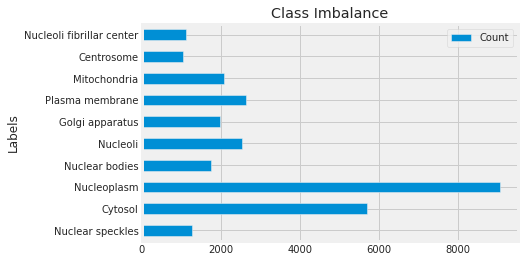

In [11]:
from itertools import chain
from collections import Counter

image_df = pd.read_csv(TRAIN_CSV)


all_labels = list(chain.from_iterable([i.strip().split(" ") 
                                       for i in image_df['Label'].values]))

c_val = []    
c_val = Counter(all_labels)

n_keys = c_val.keys()
max_idx = max(n_keys)

counts = pd.DataFrame({
    "Labels": [labels[int(key)] for key in c_val.keys()],
    "Count": [val for val in c_val.values()]
})

counts.plot(x="Labels", y='Count', kind='barh', title='Class Imbalance')

counts.sort_values(by="Count", ascending=False).style.background_gradient(cmap='Reds')

* We can clearly see there class imbalance in the dataset.
* To overcome this we can use data augmentations techniques.

## Data Augmentation

Let's first take a look at some images

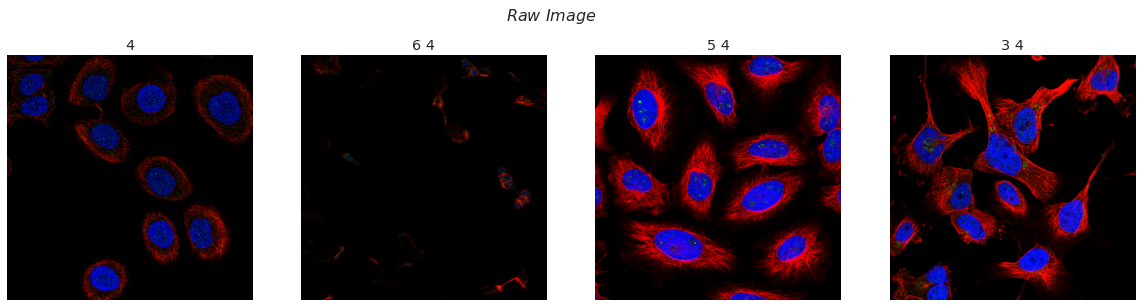

In [12]:
import matplotlib.image as mpimg

plt.figure(figsize=(18, 10))

images = os.listdir(TRAIN_DIR)

for i in range(4):
    plt.subplot(1, 4, i+1)
    rand_image = np.random.choice(images)
    image_path = os.path.join(TRAIN_DIR, rand_image)
    image_number = image_path.split('/')[-1][:-4]
    label_ = data_df.Label.loc[data_df.Image == int(image_number)].to_list()
    image = mpimg.imread(image_path)
    plt.title(label_[0])
    plt.imshow(image)
    plt.axis("off")
    
_ = plt.suptitle("$Raw$ $Image$", y=0.74, fontsize=16)

* We're going to apply various augmentation techniques.
* All available transformations are listed in : [pytorch transforms](https://pytorch.org/docs/stable/torchvision/transforms.html)
* A quick illustration on how the augmentaions affect the images: [kaggle - Image Augmentation for more train data](https://www.kaggle.com/vishnurapps/image-augmentation-for-more-training-data)

In [13]:
def image_transformations(image_size: int) -> (object, object):
    '''
        Return transformations to be applied.
        Input:
            image_size: int
        Output:
            train_transformations: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''

    imagenet_stats = ([0.05438065, 0.05291743, 0.07920227], [0.39414383, 0.33547948, 0.38544176])

    train_trans = [           
        T.Resize(image_size + 4),
        T.RandomCrop(image_size, padding=8, padding_mode='reflect'),
        T.RandomRotation(90),
        T.RandomAffine(
            degrees=(-45,45),
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        T.RandomHorizontalFlip(p=0.6), 
        T.RandomVerticalFlip(p=0.4),
        T.ToTensor(),
        T.Normalize(*imagenet_stats, inplace=True),
        T.RandomErasing(inplace=True, scale=(0.02, 0.44), ratio=(0.4, 4.4))
    ]

    val_trans = [
        T.Resize(image_size), 
        T.ToTensor(), 
        T.Normalize(*imagenet_stats, inplace=True)
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

## Dataset & DataLoaders

* Here we are going to define functions to fetch training and testing datasets
* The train dataset is split into training and validation set of  [90, 10].
* The test dataset should not used until the final prediction generation.

In [14]:
def get_train_dataset(image_size: int) -> (object, object):
    ''' get training_dataset
        Input:
            image_size: int
        output:
            train_ds: training dataset object
            val_ds: validation dataset object
    '''

    np.random.seed(42)  
    msk = np.random.rand(len(data_df)) < 0.9
    train_df = data_df[msk].reset_index()
    val_df = data_df[~msk].reset_index()

    # get transformation according to the architecture
    train_tfms, valid_tfms = image_transformations(image_size)

    # fetch dataset
    train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
    val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
    return train_ds, val_ds

In [15]:
def get_train_dataloader(image_size: int, batch_size: int=64) -> (object, object):
    '''
        Returns train and test dataloaders.
        Input:
            image_size: int
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''

    train_ds, valid_ds = get_train_dataset(image_size)

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)
    
    return train_dl, valid_dl

In [16]:
def get_test_dataloader(image_size: int, batch_size: int=64) -> object:
    '''
        Returns test set dataloaders.
        Input:
            image_size: int
            batch_size: [optional] int
        Output:
            test_dl: test dataloader object
    '''

    test_df = pd.read_csv(TEST_CSV)

    # get transformations same as validation set
    _, valid_tfms = image_transformations(image_size)
    
    test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)
    test_dl = DeviceDataLoader(test_dl, device)
    return test_dl

# Model building 

* For this problem I chose to experiment with the SOTA CNN architecture `EfficientNet-b*`.
* EfficientNet paper: [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)
* A new technique which improves EfficientNet models: [Adversarial Examples Improve Image Recognition](https://arxiv.org/abs/1911.09665)


## Setting up GPU usage

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

## Defining Model

* Testing for B1 - B4

In [19]:
models = {
#     "EfficientNet-b0": EfficientNet.from_pretrained('efficientnet-b0'),
    "EfficientNet-b1": EfficientNet.from_pretrained('efficientnet-b1'), 
#     "EfficientNet-b2": EfficientNet.from_pretrained('efficientnet-b2'),
#     "EfficientNet-b3": EfficientNet.from_pretrained('efficientnet-b3'),
}

image_sizes = {
    "EfficientNet-b0": 224,
    "EfficientNet-b1": 240,
    "EfficientNet-b2": 260,
    'EfficientNet-b3': 300,
    'EfficientNet-b4': 380,
}

batch_sizes = {
    "EfficientNet-b0": 150,
    "EfficientNet-b1": 100,
    "EfficientNet-b2": 64,
    'EfficientNet-b3': 50,
    'EfficientNet-b4': 20
}

Loaded pretrained weights for efficientnet-b1


## Scoring mechanism

In [20]:
def F_score(output: list, label: list, threshold: float=THRESHOLD, beta: float=1.0) -> float:
    '''
        Returns the F-score for the model
        Input:
            output: array of outputs
            label: array of labels
            treshold: optionfloat -> consider output probablity if above the index
            beta: [optional] float
        Output:
            float -> F-score
    '''

    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

## Model Class

In [21]:
# This class can be used for any Image Classification problem

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        score = F_score(out, targets)
        return {'loss': loss, 'score': score.detach()}

    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = 'val_loss'
            score_ = 'val_score'
        else:
            loss_ = 'loss'
            score_ = 'score'

        batch_losses = [x[f'{loss_}'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_scores = [x[f'{score_}'] 
                        for x in outputs]
        epoch_scores = torch.stack(batch_scores).mean()      
        return {f'{loss_}': epoch_loss.item(), f'{score_}': epoch_scores.item()}
    
    def epoch_end(self, epoch, result, epochs):
        print(f"Epoch: {epoch+1}/{epochs} -> last_lr: {result['lrs'][-1]:.4f}, train_loss: {result['loss']:.4f}, train_score: {result['score']:.4f}, val_loss: {result['val_loss']:.4f}, val_score: {result['val_score']:.4f}")


In [22]:
class ProteinModel(MultilabelImageClassificationBase):

    @staticmethod
    def get_sequential(num_ftrs):
        linear_layers = nn.Sequential(
                nn.BatchNorm1d(num_features=num_ftrs),    
                nn.Linear(num_ftrs, 10),

            )
        return linear_layers

    def __init__(self, model_name=None, model=None, input_size=None):
        super().__init__()
        
        # Use a pretrained model
        self.model_name = model_name
        self.model = copy.deepcopy(model)
        self.IS = input_size
        
        # Replace last layer
        self.num_ftrs = self.model._fc.in_features
        self.model._fc = ProteinModel.get_sequential(self.num_ftrs)

    def forward(self, xb):
        return torch.sigmoid(self.model(xb))

    def freeze(self):
        
        # To freeze the residual layers
        for param in self.model.parameters():
            param.require_grad = False

        for param in self.model._fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.require_grad = True

    def __repr__(self):
        return f"{self.model}"
    
    def __str__(self):
        summary(self.model, (3, self.IS, self.IS))
        text_ = \
        f'''
            Model Name: {self.model_name}
            FC Layer input: {self.num_ftrs}
        '''
        return text_

## Helper functions

In [23]:
@torch.no_grad()
def evaluate(model: object, val_loader: object) -> dict:
    '''
        Evaluate model on the validation set
        Input:
            model: training model object
            val_loder: validation data loader object
        Output:
            validation metrics
    '''

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def get_lr(optimizer: object) -> float:
    ''' Returns current learning rate'''

    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_model(model_name: str,
              model: object, 
              epochs: int, 
              lr: float, 
              train_loader: object, 
              val_loader: object,
              opt_func: object=torch.optim.SGD):
    '''
        This function is responsible for training our model.
        We use a One Cycle learning rate policy to update our learning rate 
        with each epoch.
        The best model is saved during each epoch.
        Input:
            model_name: str 
            model: object
            epochs: int -> Max epochs
            lr: float -> learning rate
            train_loader: training set data loader
            val_loader: validation set data loader
            opt_func: optimzer object
        Output:
            history: list of metrics
    '''


    
    torch.cuda.empty_cache()
    BEST_VAL_SCORE = 0.0 # for keeping track of best model score
    history = []

    optimizer = opt_func(model.parameters(), lr)

    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=max_lr,
    #                                                 epochs=epochs, 
    #                                                 steps_per_epoch=len(train_loader))
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.01)
    
    print(f"Transfer Learning -> Model: {model_name}") 
    for epoch in range(epochs):

        # unfreeze for last 50% of epochs
        if epoch == (epochs // 2):
            model.unfreeze()
            print(f"Fine-tuning: {model_name}")
#             optimizer = opt_func(model.parameters(), unfreeze_max_lr, 
#                                  weight_decay=weight_decay)
            
#             scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,  
#                                                             max_lr=unfreeze_max_lr, 
#                                                             epochs=epochs//2,  
#                                                             steps_per_epoch=len(train_loader))
        
        # log epoch metrics
        train_history = []
        lrs = []

        # Training Phase 
        model.train()
        
        for batch in tqdm(train_loader, desc=f'Epoch: {epoch+1}/{epochs}'):
            info = model.training_step(batch)
            loss = info['loss']
            # contains batch loss and acc for training phase
            train_history.append(info)
            loss.backward()

            # Gradient clipping
            # if grad_clip:
            #     nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            # scheduler.step()


        train_result = model.get_metrics_epoch_end(train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        
        # call scheduler to check validation loss
        scheduler.step(result['val_score'])

        result['lrs'] = lrs
        model.epoch_end(epoch, result, epochs)


        # Save the best model
        if result['val_score'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_score']
            save_name = f"{model_name}_epoch-{epoch+1}_score-{round(result['val_score'], 4)}.pth"
            !rm -f '{model_name}'_*
            torch.save(model.state_dict(), save_name)
            
            # generate predictions using the best model
            
            print("Genearating predictions on the Test set")
            generate_prediction(model, image_sizes[model_name])

        history.append(result)
    return history

In [24]:
# functions to fetch test dataset and generate submission file for best model

def load_best(model_name: str) -> object:
    '''Returns the best model'''

    model = models[model_name]
    image_size = image_sizes[model_name]
    best_model = ProteinModel(model_name, model, image_size)

    # load trained weights
    path = r"./"
    file_path = ''
    
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and i.startswith('EfficientNet'):
            file_path = os.path.join(path, i)
            
    print(f"Loading model: {file_path[2:]}")
    best_model.load_state_dict(torch.load(file_path))
    # set model to gpu
    best_model = to_device(best_model, device)
    return best_model   


@torch.no_grad()
def generate_prediction(model: object, image_size: int) -> None:
    '''Generate prediction on the test set and creates a csv file'''

    test_dl = get_test_dataloader(image_size)

    model.eval()
    # clear cuda cache
    torch.cuda.empty_cache()

    # generate predictions
    batch_probs = []
    for xb, _ in tqdm(test_dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    test_preds = [decode_target(x) for x in batch_probs]

    # generate submistion file
    submission_df = pd.read_csv(TEST_CSV)
    submission_df.Label = test_preds
    sub_fname = f'submission_{model_name}.csv'
    submission_df.to_csv(sub_fname, index=False)
    print(f"Prediction file: {sub_fname} generated")

In [25]:
def end_to_end(model_name: str, parameters: dict=None) -> dict:
    '''
        A simple function end-to-end training and testing on the selected model.
        Inputs:
            model_name: str -> chosen model name
            parameters: dict -> dictionary of hyperparameters for the model
        Outputs:
            history: dict -> dictionary containing model metrics(loss, score, lr)

    '''
    torch.cuda.empty_cache()

    # hyperparameters
    image_size = image_sizes[model_name]
    BATCH_SIZE = batch_sizes[model_name]
    epochs = parameters["epochs"]
    lr = parameters["lr"]
    opt_func = parameters["opt_func"]

    # get transformed dataset
    train_dl, valid_dl = get_train_dataloader(image_size, batch_size=BATCH_SIZE)
    # move dataset to use GPU
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    # get model
    model = models[model_name]
    model = ProteinModel(model_name, model, image_size)    
    # convert to cuda
    model = to_device(model, device)
     

    # move model to GPU
    model = to_device(model, device)
    
    # train model
    history = fit_model(
                model_name,
                model, 
                epochs, 
                lr, 
                train_dl, 
                valid_dl,
                opt_func
            )

    # cleaning
    torch.cuda.empty_cache()
    
    return history

# Train Model

In [26]:
# TRAINING CONSTANTS

training_parameters = {
    "epochs": 20,
    "lr": 0.001,
    "opt_func": torch.optim.Adam,
    "batch_size": 128,
}

**Demo Run**

In [27]:
model_name = "EfficientNet-b1"

history = end_to_end(model_name, training_parameters)

Epoch: 1/20:   0%|          | 0/174 [00:00<?, ?it/s]

Transfer Learning -> Model: EfficientNet-b1


Epoch: 1/20: 100%|██████████| 174/174 [03:11<00:00,  1.10s/it]


Epoch: 1/20 -> last_lr: 0.0010, train_loss: 0.3872, train_score: 0.5193, val_loss: 0.3451, val_score: 0.5607


  0%|          | 0/129 [00:00<?, ?it/s]

Genearating predictions on the Test set


Epoch: 2/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 2/20: 100%|██████████| 174/174 [03:16<00:00,  1.13s/it]


Epoch: 2/20 -> last_lr: 0.0010, train_loss: 0.2450, train_score: 0.6684, val_loss: 0.3001, val_score: 0.6615


  0%|          | 0/129 [00:00<?, ?it/s]

Genearating predictions on the Test set


Epoch: 3/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 3/20: 100%|██████████| 174/174 [03:15<00:00,  1.12s/it]


Epoch: 3/20 -> last_lr: 0.0010, train_loss: 0.2269, train_score: 0.7025, val_loss: 0.2315, val_score: 0.7121


  0%|          | 0/129 [00:00<?, ?it/s]

Genearating predictions on the Test set


Epoch: 4/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 5/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 4/20 -> last_lr: 0.0010, train_loss: 0.2145, train_score: 0.7229, val_loss: 0.2334, val_score: 0.6674


Epoch: 5/20: 100%|██████████| 174/174 [03:06<00:00,  1.07s/it]


Epoch: 5/20 -> last_lr: 0.0000, train_loss: 0.2018, train_score: 0.7373, val_loss: 0.1933, val_score: 0.7615
Genearating predictions on the Test set


Epoch: 6/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 6/20: 100%|██████████| 174/174 [03:13<00:00,  1.11s/it]


Epoch: 6/20 -> last_lr: 0.0000, train_loss: 0.1962, train_score: 0.7498, val_loss: 0.1892, val_score: 0.7656


  0%|          | 0/129 [00:00<?, ?it/s]

Genearating predictions on the Test set


Epoch: 7/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 7/20: 100%|██████████| 174/174 [03:12<00:00,  1.11s/it]


Epoch: 7/20 -> last_lr: 0.0000, train_loss: 0.1933, train_score: 0.7551, val_loss: 0.1867, val_score: 0.7688


  0%|          | 0/129 [00:00<?, ?it/s]

Genearating predictions on the Test set


Epoch: 8/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 9/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 8/20 -> last_lr: 0.0000, train_loss: 0.1906, train_score: 0.7586, val_loss: 0.1866, val_score: 0.7683


Epoch: 9/20: 100%|██████████| 174/174 [03:06<00:00,  1.07s/it]


Epoch: 9/20 -> last_lr: 0.0000, train_loss: 0.1912, train_score: 0.7592, val_loss: 0.1871, val_score: 0.7695
Genearating predictions on the Test set


Epoch: 10/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 11/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 10/20 -> last_lr: 0.0000, train_loss: 0.1920, train_score: 0.7578, val_loss: 0.1867, val_score: 0.7694
Fine-tuning: EfficientNet-b1


Epoch: 11/20: 100%|██████████| 174/174 [03:07<00:00,  1.08s/it]


Epoch: 11/20 -> last_lr: 0.0000, train_loss: 0.1911, train_score: 0.7557, val_loss: 0.1868, val_score: 0.7698
Genearating predictions on the Test set


Epoch: 12/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 13/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 12/20 -> last_lr: 0.0000, train_loss: 0.1923, train_score: 0.7549, val_loss: 0.1868, val_score: 0.7689


Epoch: 14/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 13/20 -> last_lr: 0.0000, train_loss: 0.1911, train_score: 0.7567, val_loss: 0.1868, val_score: 0.7686


Epoch: 15/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 14/20 -> last_lr: 0.0000, train_loss: 0.1927, train_score: 0.7542, val_loss: 0.1869, val_score: 0.7694


Epoch: 16/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 15/20 -> last_lr: 0.0000, train_loss: 0.1920, train_score: 0.7562, val_loss: 0.1870, val_score: 0.7670


Epoch: 17/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 16/20 -> last_lr: 0.0000, train_loss: 0.1924, train_score: 0.7564, val_loss: 0.1871, val_score: 0.7690


Epoch: 17/20: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]


Epoch: 17/20 -> last_lr: 0.0000, train_loss: 0.1900, train_score: 0.7575, val_loss: 0.1868, val_score: 0.7707
Genearating predictions on the Test set


Epoch: 18/20:   0%|          | 0/174 [00:00<?, ?it/s]

Prediction file: submission_EfficientNet-b1.csv generated


Epoch: 19/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 18/20 -> last_lr: 0.0000, train_loss: 0.1907, train_score: 0.7591, val_loss: 0.1868, val_score: 0.7692


Epoch: 20/20:   0%|          | 0/174 [00:00<?, ?it/s]

Epoch: 19/20 -> last_lr: 0.0000, train_loss: 0.1907, train_score: 0.7576, val_loss: 0.1865, val_score: 0.7692


Epoch: 20/20: 100%|██████████| 174/174 [03:04<00:00,  1.06s/it]


Epoch: 20/20 -> last_lr: 0.0000, train_loss: 0.1921, train_score: 0.7552, val_loss: 0.1868, val_score: 0.7684


# Plots

In [28]:
# plotting metrics

def plot_accuracies(history):
    train_score = [r['score'] for r in history]
    val_score = [r['val_score'] for r in history]
    plt.plot(train_score, '-kx', label="train_score")
    plt.plot(val_score, '-rx', label="val_score")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_score)), 
                   labels=[str(i) for i in range(1, len(train_score)+1)])
    plt.xlabel('epoch')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs. epochs')

def plot_losses(history):
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, '-kx', label="train_loss")
    plt.plot(val_losses, '-rx', label="val_loss")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_losses)), 
                   labels=[str(i) for i in range(1, len(train_losses)+1)])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

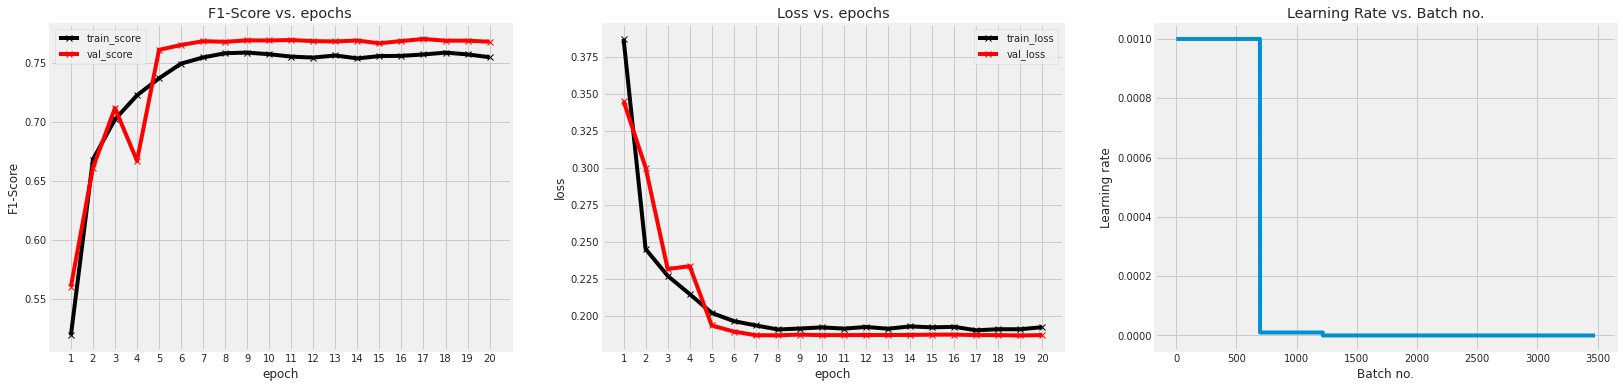

In [29]:
# plotting score and loss
plt.figure(figsize=(25, 6))
plt.subplot(1, 3, 1)
plot_accuracies(history)
plt.subplot(1, 3, 2)
plot_losses(history)

plt.subplot(1, 3, 3)
plot_lrs(history)